In [1]:
from importlib import reload
import flymovie as fm
import cnn_models
import cnn_models.siamese_cnn as cn
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
from pathlib import Path
import scipy.spatial
import scipy.ndimage as ndi
import tensorflow as tf
from importlib import reload
%load_ext autoreload
%autoreload 2

## Goals

1. Design a test for the performance of an embedding

2. Design a way to apply curriculum learning to my siamese CNN network.


### 1. Designing a test for the performance of an embedding

My strategy is to first construct a test set of images, feed those images through a candidate embedding, and determine the success of the network based on how well similar images are clustered together. Some options:
    - top N accuracy: how often is the most-similar non-self image in the top N
    - Mean ranking of top N: rank images by actual similarity (based on sim parameters), rank them by embedding distance, compare. I think I'll start with just the sum of the squared rank differences. I can probably adapt this to be something with useful statistical properties eventually but no need right now.


In [24]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/checkpoint_testmodel'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=18)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [91]:
from cnn_models.siamese_cnn import preprocess_image

############################################################################
def embed_images(im_folder, embedding, mip=False):
    """Pass images from a folder through embedding, return their location 
    and simulation parameters."""
    
    def normalize_params(params):
        std = np.std(params, axis=0)
        # If the parameter is fixed it will have std=0. Since the difference
        # will be 0 and the desired value is all 0, any non-zero value for 
        # std works to avoid divide by 0 error.
        std[std == 0] = 1e6
        p = params.copy()
        p = (p - p.mean(axis=0)) / std
        return p
        
    ims = []
    files = os.listdir(im_folder)
    num_params = len(files[-1].split('_')) - 2
    params = np.ndarray((0, num_params))

    # Load images and extract parameters.
    for f in files:
        if f[3] != '_':
            continue
        # Because of the silliness with extracting filename from tensor, 
        # have to add two single quotes flanking filename.
        filename = "_'" + os.path.join(im_folder, f) + "'_"
        im = preprocess_image(filename, mip)
        ims.append(im)
        p= f.split('_')[1:-1]
        p = [float(x) for x in p]
        params = np.vstack([params, p])
    
    params = normalize_params(params)

    # Calculate embedding for each image.
    im_embeddings = np.ndarray((0,256))
    for i in range(len(ims)):
        im = ims[i]
        im = np.expand_dims(im, axis=0)
        e = embedding(im).numpy()
        im_embeddings = np.vstack([im_embeddings, e])
        
    return im_embeddings, params

############################################################################
def sort_by_distance(data, n):
        ref = data[n, :]
        f = lambda x: scipy.spatial.distance.euclidean(x, ref)
        dists = np.apply_along_axis(f, 1, data)
        indxs = np.argsort(dists)
        return indxs[1:]

############################################################################
def top_n_accuracy(im_embeddings, params, n):
    if im_embeddings.shape[0] != params.shape[0]:
        raise ValueError('Row number does not match.')
    
    num_images = im_embeddings.shape[0]
    rank_sq_diff_sums = []
    best_in_topn_count = 0

    for i in range(num_images):
        embedding_dist = sort_by_distance(im_embeddings, i)
        param_dist = sort_by_distance(params, i)
        best_idx = param_dist[0]
        if best_idx in embedding_dist[:n]:
            best_in_topn_count += 1
        rank_sq_diff_sum = np.sum((embedding_dist[:n] - param_dist[:n]) ** 2)
        rank_sq_diff_sums.append(rank_sq_diff_sum)
    
    accuracy = best_in_topn_count / num_images
    print('Top ' + str(n) + ' accuracy: ' + str(accuracy))
    rank_sq_diff_mean = np.mean(rank_sq_diff_sums)
    print('Top ' + str(n) + ' rank square difference mean: ' + str(rank_sq_diff_mean))
        


In [41]:
im_embeddings, params = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_AdBkIaWE', embedding)

(10, 256)

In [92]:
top_n_accuracy(im_embeddings, params, 5)

Top 5 accuracy: 0.9
Top 5 rank square difference mean: 72.4


In [101]:
top_n_accuracy(np.random.random((150,10)), np.random.random((150,10)), 5)

Top 5 accuracy: 0.013333333333333334
Top 5 rank square difference mean: 19656.12


### 2. Refactoring siamese cnn to use curriculum learning



In [104]:
# Set up input directories.
from pathlib import Path
folder = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir=folder
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [195]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

negative_images = anchor_images + positive_images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)   

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset)) 
#dataset = dataset.shuffle(buffer_size=1024)

### Below is the new strategy

No longer use shuffling of negative dataset. Start by pairing files (as lists). Will do a scheme where it accepts some parameter (num_negative_pairs maybe) and for each AP pair, generates that many negative pairings that are within some margin in parameter distance. The result will be three ordered lists. Make three datasets from these, zip them, shuffle, and use the take method to select subset.

This way I generate num_images * num_negative_pairs possible APN filename pairings, Randomly sample from those for training sets.

Basically: first generate an excess number of triplets that satisfy margin, randomly sample from those as opposed to doing the shuffling online.

## Goals 2022-02-14

1. Implement the above

2. Comment and test cnn module (ugh). Get it in order.

In [214]:
a = np.arange(1000)
n = np.arange(2000)
a_dataset = tf.data.Dataset.from_tensor_slices(a)
p_dataset = tf.data.Dataset.from_tensor_slices(a)
n_dataset = tf.data.Dataset.from_tensor_slices(n)

dataset = tf.data.Dataset.zip((a_dataset, p_dataset, n_dataset)) 
dataset = dataset.shuffle(5000)
dataset = dataset.take(1)


In [230]:
count = 0

for i in dataset:
    print(i)

(<tf.Tensor: shape=(), dtype=int64, numpy=902>, <tf.Tensor: shape=(), dtype=int64, numpy=902>, <tf.Tensor: shape=(), dtype=int64, numpy=902>)


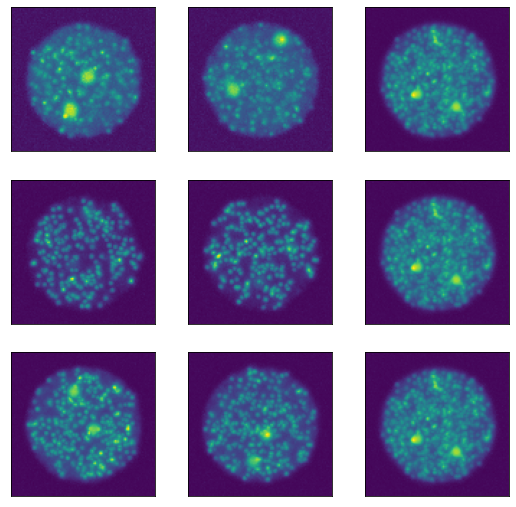

In [144]:
iter = dataset.as_numpy_iterator()

def show(ax, image):
        ax.imshow(image, vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    a = next(iter)
    show(axs[i, 0], a[0].max(axis=0))
    show(axs[i, 1], a[1].max(axis=0))
    show(axs[i, 2], a[2].max(axis=0))

In [183]:
#cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_715_ylolCRqp')
left = cache_dir / 'left'
right = cache_dir / 'right'
anchor = sorted(
        [str(left / f) for f in os.listdir(left)]
    )

positive = sorted(
        [str(right / f) for f in os.listdir(right)]
    )

In [229]:
def fake_files(n):
    l = []
    for _ in range(n):
        f = 'aaa'
        for _1 in range(9):
            f = f + '_' + str(np.random.randint(0,100))
        f = f + '_rep0.pkl'
        l.append(f)
    return l

anchor = fake_files(10_000)
positive = fake_files(10_000)

In [230]:
#---------------------------------------------------------------------------
def match_triplets(anchor_files, positive_files, num_negatives=5, 
    upper_margin=10, lower_margin=0):
    """Make file lists that match anchor-positive pairs with negative images
    within a margin of similarity.

    Image similarity is defined by using the euclidean distance between the 
    (normalized) simulation parameters. The margins are determined by
    randomly sampling image pairs to generate a distribution of parameter
    distances, then using percentiles from that distribution (percentiles
    defined by supplied upper and lower margins) to define the allowable
    distances for negative images.
    
    Images are selected by the following algorithm:
        1. Extract simulation parameters from all file names.
        2. Normalize each parameter (Z-scores)
        3. Randomly sample image pairs, calculate the euclidean distance
            between parameters for each pair, then get distance cutoffs 
            based on percentiles from this distribution.
        4. For each anchor-positive pair, randomly shuffle negative images.
        5. Search in order through shuffled negatives until a negative image
            is found whose normalized (by mean and SD found in 3) distance
            is within the bounds defined by margin parameters, 
        6. Repeat 5 until num_negatives is reached
    
    Programming note: the slowest part of this (normally) is the sampling in 
    get_param_stats, which is fine, but I think fewer pairs can be sampled
    and still get good stats if the timing is a real problem.

    Args:
        anchor_files: file path
            Iterable of files containing anchor images
        positive_files: file path
            Iterable of files containing positive images
        num_negatives: int
            The number of A-P-N triplets to make for each A-P pair
        upper_margin: number
            Percentile defining the upper limit of image similarity
            for drawing negative images (50 limits images to the 
            most similar half)
        lower_margin: number
            Percentile defining the lower limit of image similarity
            for drawing negative images (50 limits images to the 
            least similar half)

    Returns:
        a, p, n: lists
            Ordered lists of filepaths for anchor, positive, and negative
            images

    """
    def get_params_from_filename(filepath):
        """Extract simulation parameters from filename as floats."""
        filename = filepath.split('/')[-1]
        p = filename.split('_')[1:-1]
        p = [float(x) for x in p]
        return p

    def get_norm_params(filename, means, stds):
        """Z-score normalize parameters."""
        p= get_params_from_filename(filename)
        return (p - means) / stds

    def get_param_stats(files):
        """Get the mean and std for simulation parameters across the dataset,
        and get the mean and std for the euclidean distances between parameters 
        of sampled image pairs."""

        num_params = len(get_params_from_filename(files[-1]))
        params = np.ndarray((0, num_params))

        # Load images and extract parameters.
        for f in files:
            p= get_params_from_filename(f)
            params = np.vstack([params, p])
        
        # Calculate the mean and std for parameters.
        param_stds = params.std(axis=0)
        param_means = params.mean(axis=0)

        # Sample image pairs, get mean and std for distances.
        distances = []
        for _ in range(5_000):
            rs = np.random.RandomState()
            params1 = get_norm_params(rs.choice(files), param_means, param_stds)
            params2 = get_norm_params(rs.choice(files), param_means, param_stds)
            dist = scipy.spatial.distance.euclidean(params1, params2)
            distances.append(dist)

        return param_means, param_stds, distances
    

    negative_files = anchor_files + positive_files
    param_means, param_stds, dists_sampled = get_param_stats(anchor_files)
    dist_cutoff_upper = np.percentile(dists_sampled, upper_margin)
    dist_cutoff_lower = np.percentile(dists_sampled, lower_margin)

    # In case any parameters are invariant, set std to 1 to avoid divide by zero.
    # Any non-zero value works, since the distances will all be 0, and when 
    # normalized will be (0 - 0) / 1 = 0, which is the desired behavior.
    param_stds[param_stds == 0] = 1
    
    # Initialize lists to contain ordered image files.
    a, p, n = [], [], []

    for i in range(len(anchor_files)):
        anchor_params = get_norm_params(anchor_files[i], param_means, param_stds)
        negative_files_shuf = np.random.RandomState().permutation(negative_files)
        matches_count = 0
        # Search in order through shuffled negatives for images that are within 
        # the margins.
        for f in negative_files_shuf:
            # If enough matches have been found, exit for loop.
            if matches_count == num_negatives:
                break

            f_params = get_norm_params(f, param_means, param_stds)
            dist = scipy.spatial.distance.euclidean(anchor_params, f_params)
            if dist == 0:
                continue

            if (dist >= dist_cutoff_lower) and (dist <= dist_cutoff_upper):
                a.append(anchor_files[i])
                p.append(positive_files[i])
                n.append(f)
                matches_count += 1

    return a, p, n

a, p, n = match_triplets(anchor, positive, lower_margin=0, upper_margin=20, num_negatives=10)

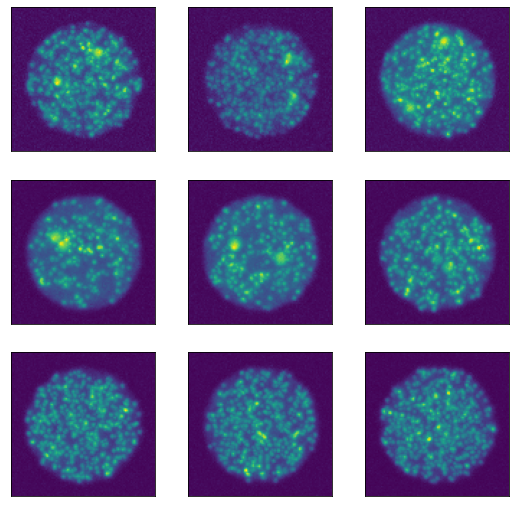

In [218]:
rand_indxs = np.random.randint(0,len(a), 3)

def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    im_a = fm.load_pickle(a[rand_indxs[i]])
    im_p = fm.load_pickle(p[rand_indxs[i]])
    im_n = fm.load_pickle(n[rand_indxs[i]])
    show(axs[i, 0], im_a.max(axis=0))
    show(axs[i, 1], im_p.max(axis=0))
    show(axs[i, 2], im_n.max(axis=0))

    

In [165]:
len(a)

40